In [2]:
!pip install seaborn scipy matplotlib scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


ВНИМАНИЕ! В блокноте собран весь код с размышлениями "успешной части" :) решения, вследствие чего к исполнению не рекомендуется из-за большого времени исполнения. В конце блокнота собран итоговый код самого лучшего submission'а, который на моём ноутбуке исполняется примерно за минуту.

# В первой части

 RobustScaler и MinMaxScaler показали ухудшение результата. В случае RobustScaler использование приведения к нормальному распределению может быть некорректным, т.к. в нуле собирается большое количество точек, что могло быть не свойственно первоначальным данным. Нужно использовать другое шкалирование или вовсе от него отказаться.
* Почти каждый следующий submission хуже предыдущего (на картинке от нового к старому, самый первый не влез):

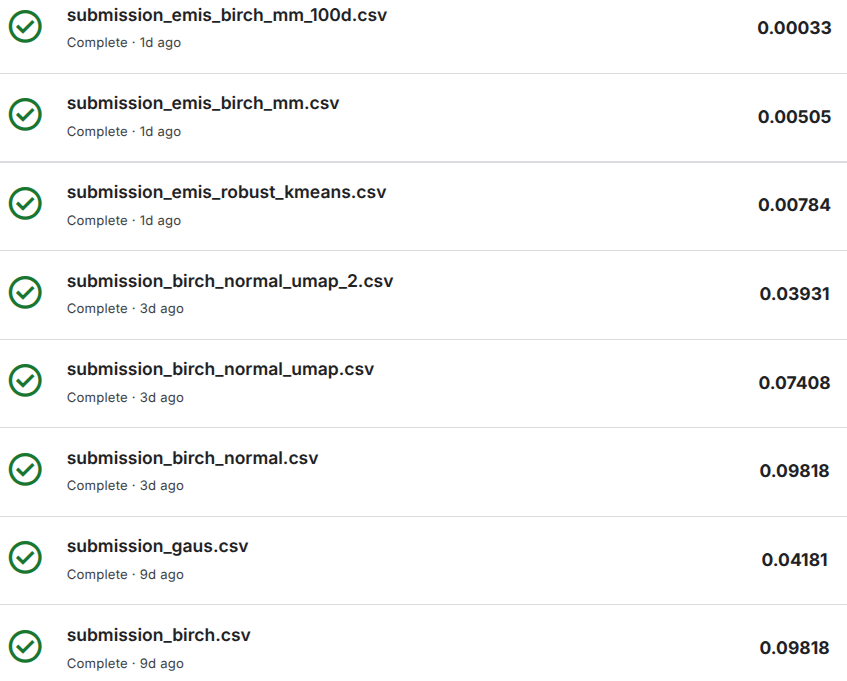

* Лучше всего себя показали PCA до 600 + Birch с random_state = 72 (Score 0.09818).
* Кажется, что при визуализации PCA показывает ситуацию более правильно, чем UMAP.

# Во второй части

Был построен график доли объясненной дисперсии.

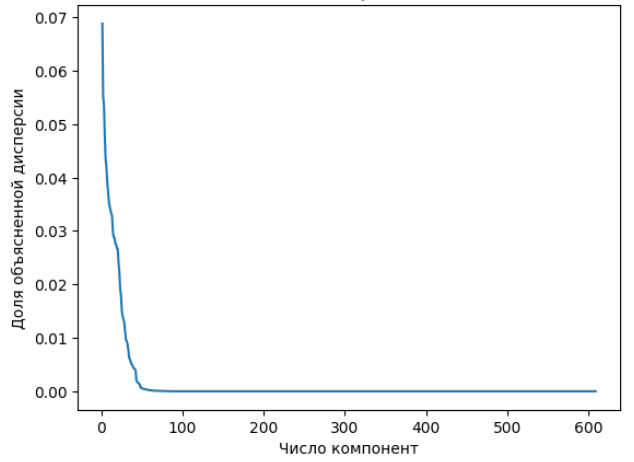

Был использован PCA с n=100 и на нем натренирован K-means. Был побит антирекорд:

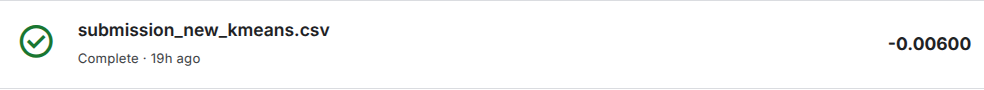

Метод локтя с K-means'ом ничего хорошего не показал.

При этом картинка выглядела неплохо (гораздо лучше, чем в остальные случаи):

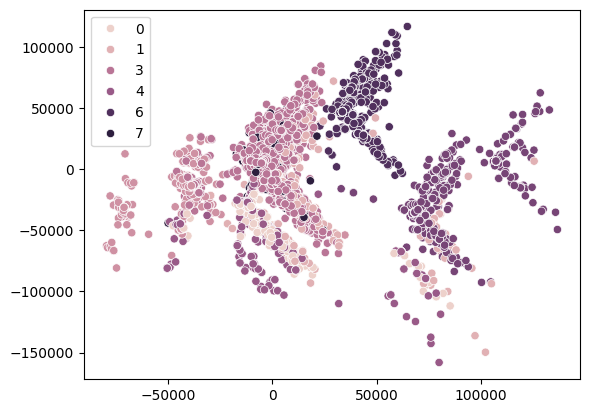

Далее возникла гипотеза, что нули представляют собой пропущенные значения (NaN). С этого момента начну.

## Загрузка данных

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster as sk_cluster
import sklearn.mixture as sk_mixture
import sklearn.preprocessing as sk_preproc
import sklearn.decomposition as sk_decomp

from sklearn import metrics
from scipy.spatial.distance import cdist
from tqdm import tqdm
import umap

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = sparse.load_npz('train.npz')
data.shape

(21000, 3049)

In [3]:
def save_pred(pred, filename):
    submission = pd.read_csv('sample_submission.csv', index_col='ID')
    submission['TARGET'] = pred
    submission.to_csv(filename)

## Очищаем данные

In [4]:
ind = np.arange(data.shape[1])[np.asarray((data != 0.0).sum(axis=0))[0] == data.shape[0]]

In [5]:
data_del = data[:, ind]

## Кластеризуем на очищенных данных

In [6]:
kmeans = sk_cluster.KMeans(n_clusters=8, random_state=14)
pred_kmeans_del = kmeans.fit_predict(data_del)

In [7]:
pca = sk_decomp.PCA(n_components=2, random_state=72)
data_del_2 = pca.fit_transform(data_del)

<Axes: >

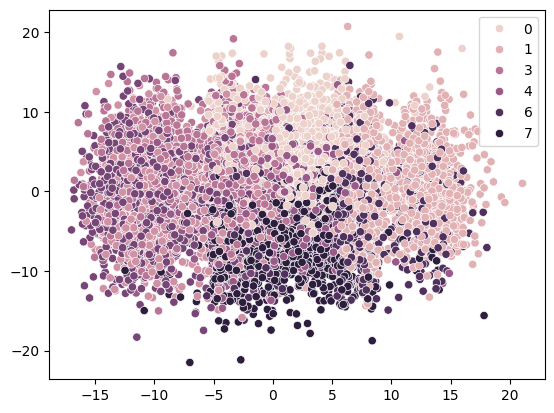

In [8]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_kmeans_del)

Для сравнения самый худший и самый лучший варианты на этих данных:

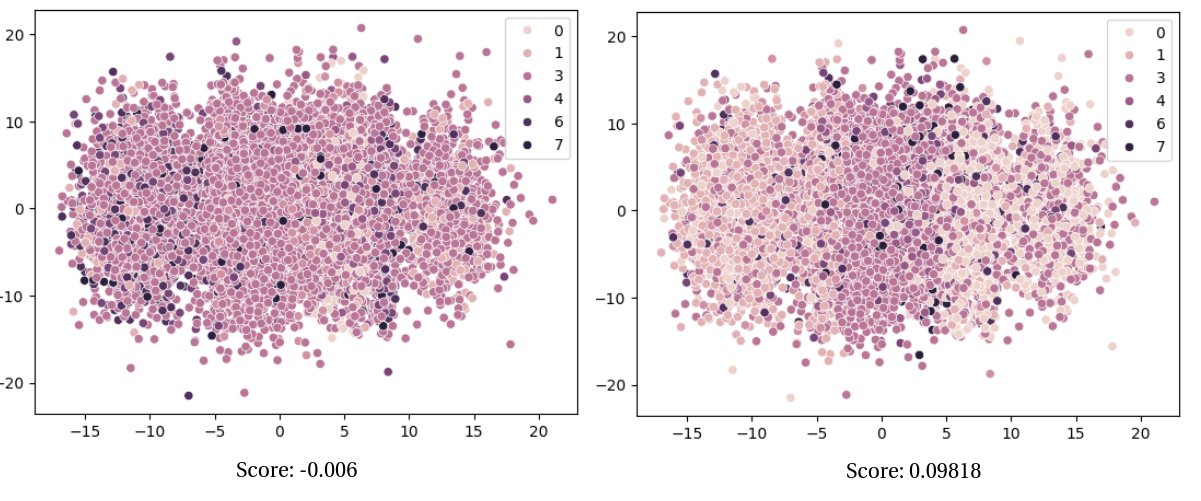

Выглядит правдоподобно. Там, где результат лучше, кластера более сгруппированы.

In [ ]:
%%time
gm = sk_mixture.GaussianMixture(n_components=8, random_state=67)
pred_gm_del = gm.fit_predict(np.asarray(data_del.todense()))

In [ ]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_gm_del)

In [ ]:
plt.hist(pred_gm_del, bins=8)

Выглядит неплохо. Попробуем.

In [ ]:
save_pred(pred_gm_del, 'submission_gm_del.csv')

Score: 0.31921

Я в шоке! Наконец-то!

## Смотрим на метрики

Здесь были собраны все мои попытки. Потом проанализирована корреляция score с различными метриками. Оставлены только картинки, чтобы не было зависимостей от файлов с моими submission.

#### Silhouette Coefficient

/tmp/ipykernel_137128/2977042814.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


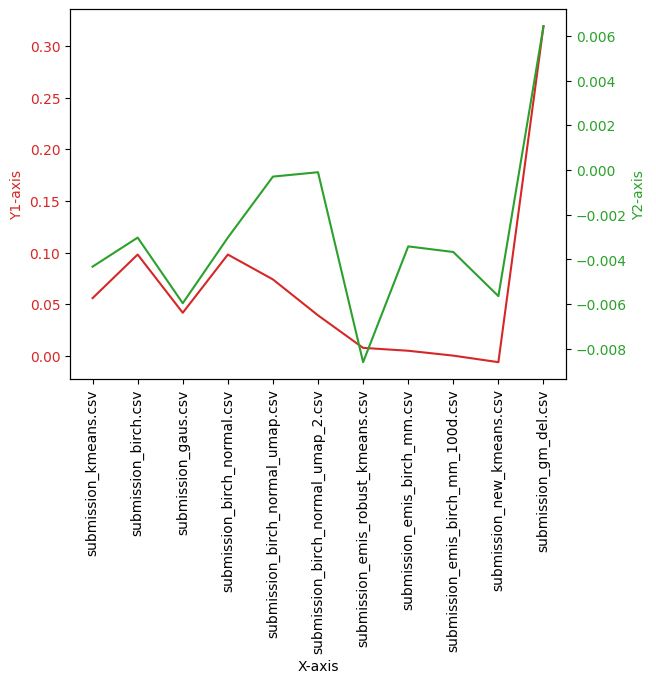

In [ ]:
# pair_plot(submissions['file'], submissions['score'], silhouette)

#### Calinski-Harabasz Index

/tmp/ipykernel_137128/2977042814.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


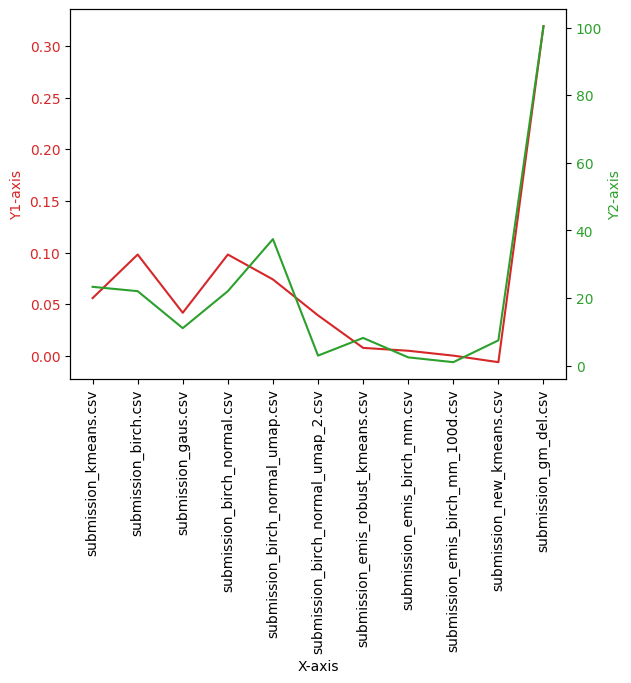

In [ ]:
# pair_plot(submissions['file'], submissions['score'], calinski)

#### Davies-Bouldin Index

/tmp/ipykernel_137128/2977042814.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


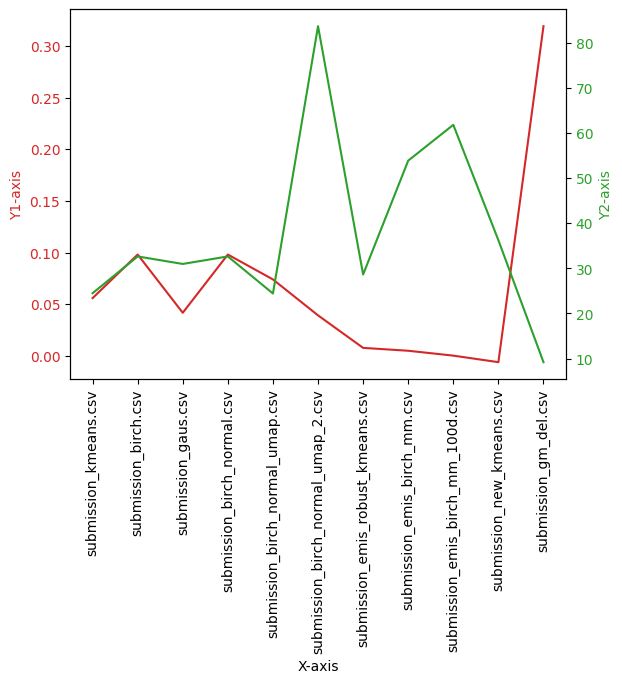

In [ ]:
# pair_plot(submissions['file'], submissions['score'], davies)

#### Выводы

Лучше всего подходит Calinski-Harabasz Index, т.к. Davies-Bouldin Index вообще ни о чем, а Silhouette Coefficient очень дорого считать.

## Пробуем докрутить GaussianMixture

### Пробуем определить количество компонент

Будем это делать с помощью Gaussian Mixture и нашей метрики

In [ ]:
K = range(2, 15, 2)
score = []

for k in tqdm(K):
    model = sk_mixture.GaussianMixture(n_components=k, random_state=67)
    pred_model = model.fit_predict(np.asarray(data_del.todense()))
    sc = metrics.calinski_harabasz_score(np.asarray(data_del.todense()), pred_model)
    score.append(sc)

100%|██████████| 7/7 [02:26<00:00, 20.97s/it]


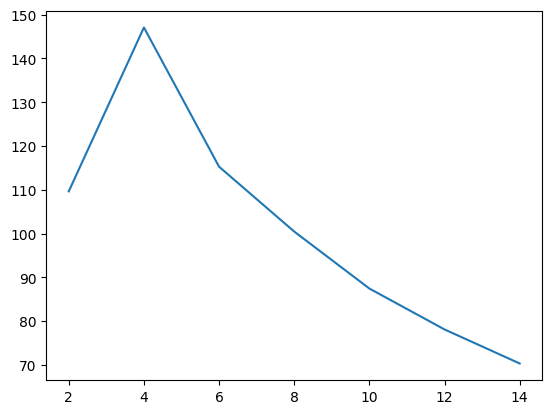

In [ ]:
plt.plot(K, score)

In [ ]:
K = range(2, 7)
score = []

for k in tqdm(K):
    model = sk_mixture.GaussianMixture(n_components=k, random_state=67)
    pred_model = model.fit_predict(np.asarray(data_del.todense()))
    sc = metrics.calinski_harabasz_score(np.asarray(data_del.todense()), pred_model)
    score.append(sc)

100%|██████████| 5/5 [01:55<00:00, 23.13s/it]


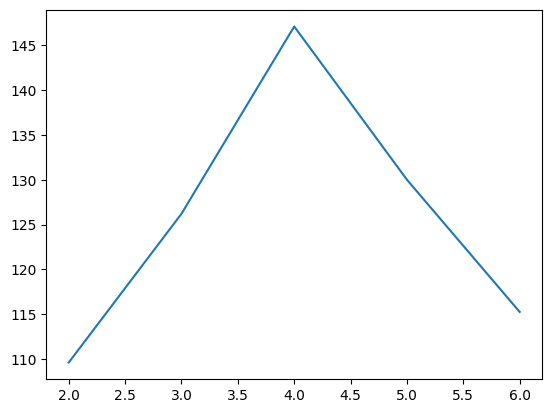

In [ ]:
plt.plot(K, score)

Итого 4 кластера (по крайней мере, для этого метода).

### Определяем random_state

Попробуем перебирать случайные random_state для увеличения метрики. 

In [ ]:
k = 20

state_score = {}

for i in tqdm(range(k)):
    state = np.random.randint(0, 200)
    model = sk_mixture.GaussianMixture(n_components=4, random_state=state)
    pred_model = model.fit_predict(np.asarray(data_del.todense()))
    sc = metrics.calinski_harabasz_score(np.asarray(data_del.todense()), pred_model)
    print(f"{state}: {sc}")
    state_score[state] = sc

  5%|▌         | 1/20 [00:27<08:41, 27.46s/it]

53: 146.34779589125532


 10%|█         | 2/20 [00:49<07:12, 24.04s/it]

178: 148.14067555156333


 15%|█▌        | 3/20 [01:13<06:50, 24.14s/it]

40: 145.87593335945724


 20%|██        | 4/20 [01:31<05:50, 21.90s/it]

159: 147.86360992850047


 25%|██▌       | 5/20 [01:53<05:24, 21.66s/it]

61: 146.05186199399924


 30%|███       | 6/20 [02:15<05:05, 21.81s/it]

1: 147.9335876986242


 35%|███▌      | 7/20 [02:37<04:47, 22.09s/it]

57: 147.31965705166945


 40%|████      | 8/20 [02:54<04:05, 20.44s/it]

32: 148.13433485988372


 45%|████▌     | 9/20 [03:16<03:49, 20.85s/it]

158: 146.7068236862685


 50%|█████     | 10/20 [03:39<03:36, 21.62s/it]

192: 147.75731823852902


 55%|█████▌    | 11/20 [03:56<03:01, 20.11s/it]

187: 148.15471713078148


 60%|██████    | 12/20 [04:15<02:37, 19.64s/it]

30: 147.17628904287733


 65%|██████▌   | 13/20 [04:35<02:18, 19.73s/it]

49: 147.47926497647248


 70%|███████   | 14/20 [04:52<01:53, 18.98s/it]

32: 148.13433485988372


 75%|███████▌  | 15/20 [05:12<01:36, 19.27s/it]

99: 147.7851637462755


 80%|████████  | 16/20 [05:30<01:16, 19.01s/it]

63: 148.49279667601485


 85%|████████▌ | 17/20 [05:49<00:57, 19.05s/it]

125: 148.0003190505493


 90%|█████████ | 18/20 [06:11<00:39, 19.85s/it]

158: 146.7068236862685


 95%|█████████▌| 19/20 [06:31<00:20, 20.02s/it]

123: 148.59898547519862


100%|██████████| 20/20 [06:56<00:00, 20.84s/it]

86: 146.92157418185292


In [ ]:
max(state_score.items(), key=lambda t: t[1])

(123, np.float64(148.59898547519862))

Результаты не сильно отличаются, но выберем 128.

### Делаем итоговое предсказание

In [ ]:
%%time
gm = sk_mixture.GaussianMixture(n_components=4, random_state=128)
pred_gm_del_opt = gm.fit_predict(np.asarray(data_del.todense()))

CPU times: user 7min 11s, sys: 5.18 s, total: 7min 16s
Wall time: 29.5 s


<Axes: >

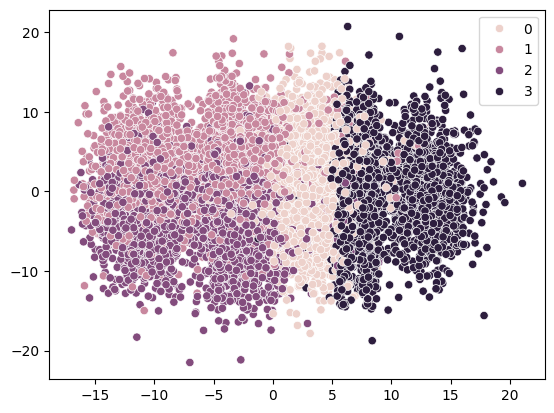

In [ ]:
sns.scatterplot(x=data_del_2[:, 0], y=data_del_2[:, 1], hue=pred_gm_del_opt)

(array([4522.,    0.,    0., 5820.,    0.,    0., 5712.,    0.,    0.,
        4946.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

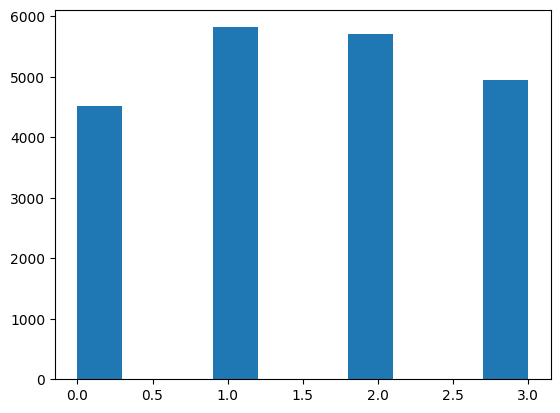

In [ ]:
plt.hist(pred_gm_del_opt)

Выборка опять получилась сбалансированной.

Проверяем:

In [ ]:
save_pred(pred_gm_del_opt, 'submission_gm_del_opt.csv')

Score: 0.36017

Получше, но не сильно.

## Некоторые итоги

* Наконец-то получилось преодолеть порог simple.
* Похоже, что Calinski-Harabasz Index показывает действительность (хотя может быть просто совпало).
* Похоже, что нули действительно обозначают NaN.
* GaussianMixture неплохо себя показал.

Что ещё можно попробовать:
* Не удалять все столбцы с нулями. Если нулей немного, то можно заполнять средним значением.
* Другие методы. Для них можно перебирать количество компонент и другие параметры.
* UMAP.

# Часть третья

## Работаем с данными

Проанализируем количество нулей в столбцах (чтобы быстрее выполнялось, будем смотреть сначала количество ненулевых значений).

In [36]:
zero_count = np.asarray(data.shape[0] - (data != 0).sum(axis=0))[0]

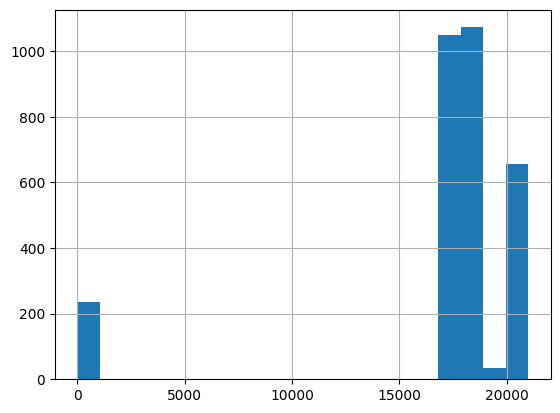

In [37]:
plt.hist(zero_count, bins=20)
plt.grid()

In [17]:
data_del.shape

(21000, 236)

In [16]:
len(zero_count[zero_count < 1000])

236

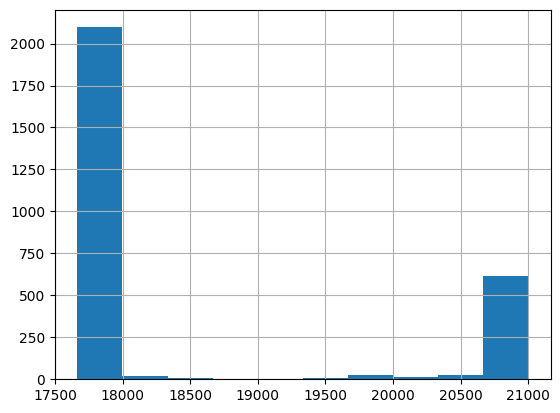

In [24]:
plt.hist(zero_count[zero_count > 15000])
plt.grid()

Так не получается.

Пойдем с другой стороны. В первой части возникло предположение, что некоторые признаки бинарные. Снова найдем эти столбцы.

In [6]:
%%time
feat_uniq_count = defaultdict(list)
for i in range(data.shape[1]):
    column_data = np.array(data[:, i].todense())[:, 0]
    uniq = np.unique(column_data)
    count_uniq = len(uniq)
    feat_uniq_count[count_uniq].append(i)

CPU times: user 45.5 s, sys: 20.8 ms, total: 45.5 s
Wall time: 45.6 s


In [5]:
len(feat_uniq_count[1])

616

На графике как раз видны эти 616 константных признака.

In [6]:
len(feat_uniq_count[2]), len(feat_uniq_count[3])

(405, 157)

405 потенциальных бинарных признаков и 157 признаков с тремя значениями. Рассмотрим бинарные признаки.

In [7]:
%%time
uniq_vals = {}
for col in feat_uniq_count[2]:
    column_data = np.array(data[:, col].todense())[:, 0]
    uniq, counts = np.unique(column_data, return_counts=True)
    uniq_vals[col] = (uniq, counts)

CPU times: user 6.86 s, sys: 0 ns, total: 6.86 s
Wall time: 6.86 s


In [8]:
uniq_vals

{2: (array([0., 1.]), array([17873,  3127])),
 13: (array([0. , 0.5]), array([17826,  3174])),
 19: (array([0., 1.]), array([17871,  3129])),
 26: (array([0., 1.]), array([17953,  3047])),
 71: (array([0., 1.]), array([17787,  3213])),
 89: (array([0. , 0.5]), array([17911,  3089])),
 91: (array([0., 1.]), array([17787,  3213])),
 102: (array([-13.81551056,   0.        ]), array([ 3104, 17896])),
 118: (array([0., 1.]), array([17838,  3162])),
 124: (array([-13.81551056,   0.        ]), array([ 3079, 17921])),
 133: (array([0. , 0.5]), array([17833,  3167])),
 134: (array([-13.81551056,   0.        ]), array([ 3233, 17767])),
 136: (array([-13.81551056,   0.        ]), array([ 3125, 17875])),
 138: (array([0., 1.]), array([17884,  3116])),
 158: (array([0. , 0.5]), array([17863,  3137])),
 163: (array([0. , 0.5]), array([17781,  3219])),
 168: (array([0., 1.]), array([17781,  3219])),
 174: (array([-13.81551056,   0.        ]), array([ 3099, 17901])),
 175: (array([0., 1.]), array([178

Популярны несколько значений:

* 0
* 1
* -13.81551056
* 0.5

Причём количество нулей в каждом столбце примерно одинаковое (около 17800). Неплохо было бы посмотреть на корреляцию таких признаков.

In [28]:
%%time
feat_corr = feat_uniq_count[2]

corr_mat = np.corrcoef(data[:, feat_corr].todense().T)

CPU times: user 2.06 s, sys: 50.4 ms, total: 2.11 s
Wall time: 344 ms


<Axes: >

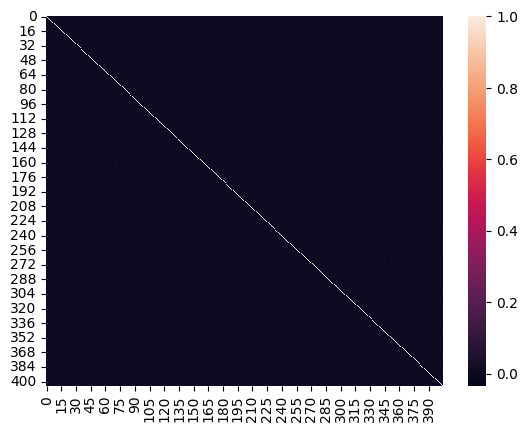

In [27]:
sns.heatmap(corr_mat)

Как будто что-то не так. Корреляция практически нулевая. Может быть это из-за большого количества нулей.

Попробуем привести эти данные к чистым бинарным признакам.

In [9]:
spec_1 = uniq_vals[174][0][0]
spec_2 = uniq_vals[219][0][1]

spec_1, spec_2

(np.float64(-13.815510557964274), np.float64(0.5))

In [10]:
(data[:, feat_uniq_count[2]] == spec_1).sum()

np.int64(326820)

In [11]:
data_clean = sparse.load_npz('train.npz')
data_clean.shape

(21000, 3049)

In [12]:
set_mask = (((data_clean[:, feat_uniq_count[2]] == spec_1) + (data_clean[:, feat_uniq_count[2]] == spec_2)) > 0)

In [14]:
data_clean[:, feat_uniq_count[2]] = np.where(set_mask.toarray(), 1.0, data_clean[:, feat_uniq_count[2]].toarray())

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Проверим:

In [15]:
%%time
uniq_vals = {}
for col in feat_uniq_count[2]:
    column_data = np.array(data_clean[:, col].todense())[:, 0]
    uniq, counts = np.unique(column_data, return_counts=True)
    uniq_vals[col] = (uniq, counts)

CPU times: user 11.7 s, sys: 4.19 ms, total: 11.7 s
Wall time: 11.7 s


In [16]:
uniq_vals

{2: (array([0., 1.]), array([17873,  3127])),
 13: (array([0., 1.]), array([17826,  3174])),
 19: (array([0., 1.]), array([17871,  3129])),
 26: (array([0., 1.]), array([17953,  3047])),
 71: (array([0., 1.]), array([17787,  3213])),
 89: (array([0., 1.]), array([17911,  3089])),
 91: (array([0., 1.]), array([17787,  3213])),
 102: (array([0., 1.]), array([17896,  3104])),
 118: (array([0., 1.]), array([17838,  3162])),
 124: (array([0., 1.]), array([17921,  3079])),
 133: (array([0., 1.]), array([17833,  3167])),
 134: (array([0., 1.]), array([17767,  3233])),
 136: (array([0., 1.]), array([17875,  3125])),
 138: (array([0., 1.]), array([17884,  3116])),
 158: (array([0., 1.]), array([17863,  3137])),
 163: (array([0., 1.]), array([17781,  3219])),
 168: (array([0., 1.]), array([17781,  3219])),
 174: (array([0., 1.]), array([17901,  3099])),
 175: (array([0., 1.]), array([17831,  3169])),
 191: (array([0., 1.]), array([17944,  3056])),
 192: (array([0., 1.]), array([17942,  3058])),


Посмотрим на признаки с тремя значениями.

In [93]:
%%time
uniq_vals = {}
for col in feat_uniq_count[3]:
    column_data = np.array(data[:, col].todense())[:, 0]
    uniq, counts = np.unique(column_data, return_counts=True)
    uniq_vals[col] = (uniq, counts)

CPU times: user 2.95 s, sys: 0 ns, total: 2.95 s
Wall time: 2.95 s


In [94]:
uniq_vals

{8: (array([-1.,  0.,  1.]), array([ 1628, 17824,  1548])),
 14: (array([-1.,  0.,  1.]), array([ 1484, 17863,  1653])),
 21: (array([-1.,  0.,  1.]), array([ 1573, 17793,  1634])),
 35: (array([-1.,  0.,  1.]), array([ 1566, 17892,  1542])),
 47: (array([-1.,  0.,  1.]), array([ 1582, 17760,  1658])),
 52: (array([-1.,  0.,  1.]), array([ 1614, 17757,  1629])),
 54: (array([-1.,  0.,  1.]), array([  228, 20543,   229])),
 60: (array([-1.,  0.,  1.]), array([ 1598, 17797,  1605])),
 67: (array([-1.,  0.,  1.]), array([ 1300, 18416,  1284])),
 77: (array([-1.,  0.,  1.]), array([ 1923, 17871,  1206])),
 103: (array([-1.,  0.,  1.]), array([ 1564, 17796,  1640])),
 112: (array([-1.,  0.,  1.]), array([ 1568, 17818,  1614])),
 113: (array([-1.,  0.,  1.]), array([ 1593, 17795,  1612])),
 120: (array([-1.,  0.,  1.]), array([ 1569, 17883,  1548])),
 121: (array([-1.,  0.,  1.]), array([ 1682, 17911,  1407])),
 205: (array([-1.,  0.,  1.]), array([ 1593, 17792,  1615])),
 262: (array([-1., 

Везде -1, 0 или 1. Количество нулей примерно одинаковое (но случаются и сильные отклонения).

Таким образом у нас уже столько признаков:

In [96]:
len(feat_uniq_count[2] + feat_uniq_count[3] + feat_uniq_count[21000])

798

Думаю, что этого будет достаточно.

In [21]:
data_clean = data_clean[:, feat_uniq_count[2] + feat_uniq_count[3] + feat_uniq_count[21000]]

Сразу сделаем данные для визуализации:

In [22]:
%%time
pca = sk_decomp.PCA(n_components=2)
data_clean_2 = pca.fit_transform(data_clean)

CPU times: user 6.41 s, sys: 3.77 ms, total: 6.41 s
Wall time: 6.17 s


<Axes: >

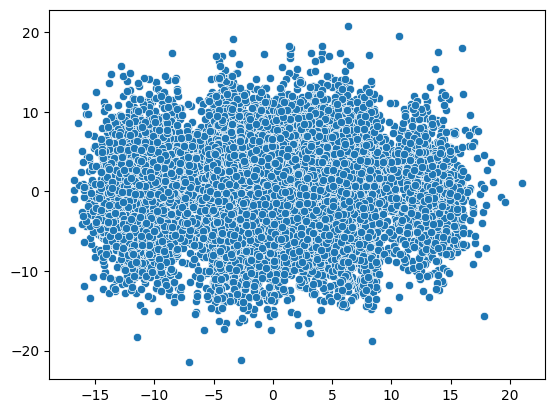

In [23]:
sns.scatterplot(x=data_clean_2[:, 0], y=data_clean_2[:, 1])

## Снова GaussianMixture

### Просто попробуем

In [24]:
%%time
gm = sk_mixture.GaussianMixture(n_components=4, random_state=123)
pred_gm_clean = gm.fit_predict(data_clean.toarray())

CPU times: user 4min 3s, sys: 3.12 s, total: 4min 6s
Wall time: 18.2 s


<Axes: >

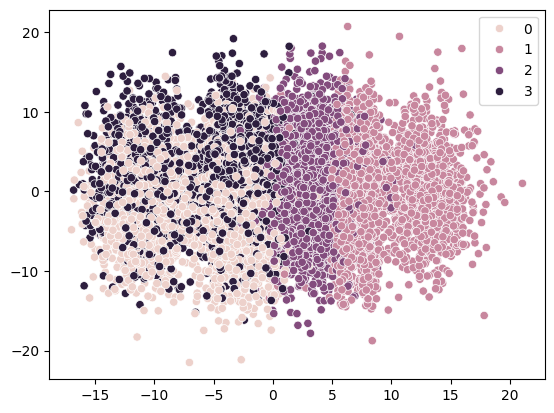

In [25]:
sns.scatterplot(x=data_clean_2[:, 0], y=data_clean_2[:, 1], hue=pred_gm_clean)

Выглядит средне, но может быть, что из-за проекции они наложились. Также это может быть из-за того, что модель предполагает нормальное распределение, а на самом деле у нас полно дискретных признаков.

In [122]:
metrics.calinski_harabasz_score(data_clean.toarray(), pred_gm_clean)

np.float64(159.13984159212063)

В этот раз метрика изменилась гораздо меньше.

### Количество компонент

In [125]:
K = range(2, 7)
score = []

for k in tqdm(K):
    model = sk_mixture.GaussianMixture(n_components=k, random_state=67)
    pred_model = model.fit_predict(data_clean.toarray())
    sc = metrics.calinski_harabasz_score(data_clean.toarray(), pred_model)
    score.append(sc)

100%|██████████| 5/5 [01:06<00:00, 13.24s/it]


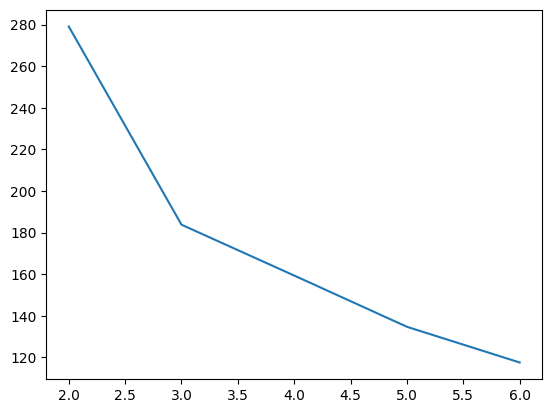

In [126]:
plt.plot(K, score)

Кажется, что бинарные признаки подпортили модели жизнь.

In [127]:
%%time
gm = sk_mixture.GaussianMixture(n_components=2, random_state=123)
pred_gm_clean = gm.fit_predict(data_clean.toarray())

CPU times: user 1min 1s, sys: 623 ms, total: 1min 2s
Wall time: 4.56 s


<Axes: >

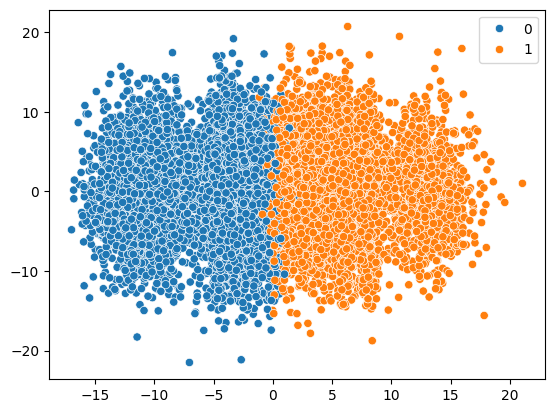

In [128]:
sns.scatterplot(x=data_clean_2[:, 0], y=data_clean_2[:, 1], hue=pred_gm_clean)

Но картинка замечательная!

## Пробуем новый метод

In [129]:
%%time
bgm = sk_mixture.BayesianGaussianMixture(n_components=4, random_state=123)
pred_bgm_clean = bgm.fit_predict(data_clean.toarray())

CPU times: user 2min 28s, sys: 1.54 s, total: 2min 30s
Wall time: 11.3 s


<Axes: >

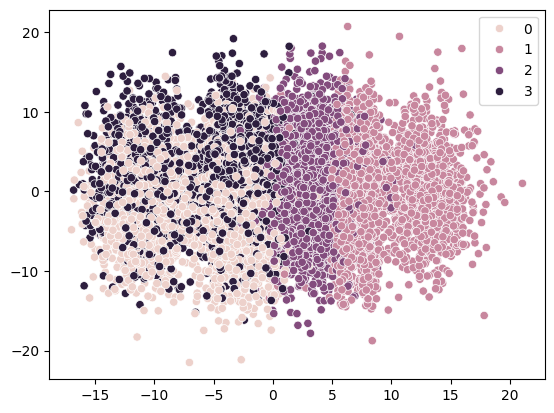

In [130]:
sns.scatterplot(x=data_clean_2[:, 0], y=data_clean_2[:, 1], hue=pred_bgm_clean)

Как будто бы две одинаковые картинки.

## K-means

In [40]:
%%time
kmeans = sk_cluster.KMeans(n_clusters=4, random_state=192)
pred_kmeans_clean = kmeans.fit_predict(data_clean.toarray())

CPU times: user 7.15 s, sys: 100 ms, total: 7.25 s
Wall time: 952 ms


<Axes: >

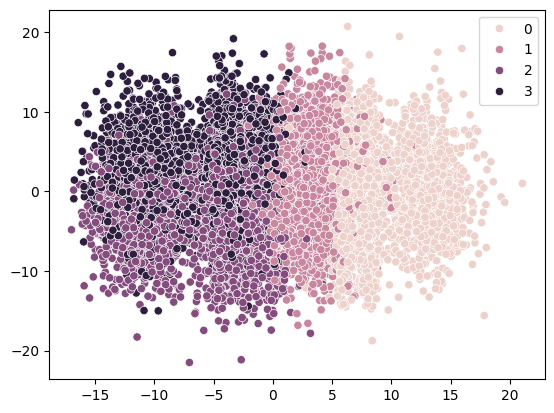

In [41]:
sns.scatterplot(x=data_clean_2[:, 0], y=data_clean_2[:, 1], hue=pred_kmeans_clean)

Красивое!

In [159]:
metrics.calinski_harabasz_score(data_clean.toarray(), pred_kmeans_clean)

np.float64(159.54347717396533)

А метрика почти такая же.

Попробуем:

In [160]:
save_pred(pred_kmeans_clean, 'submission_kmeans_clean_4.csv')

Score: 0.41283

Новый рекорд!

### Метод локтя

[Источник](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

In [136]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in tqdm(K):
    kmeanModel = sk_cluster.KMeans(n_clusters=k, random_state=72).fit(data_clean.toarray())
    
    distortions.append(sum(np.min(cdist(data_clean.toarray(), kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / data_clean.shape[0])
    
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

100%|██████████| 19/19 [00:34<00:00,  1.81s/it]


Distortion values:
1 : 2255.2977133127138
2 : 2225.7161761395528
3 : 2214.139231825566
4 : 2205.2054488469275
5 : 2199.2484973931455
6 : 2193.8440407764438
7 : 2186.6734372938213
8 : 2185.1202879037796
9 : 2179.3680520475377
10 : 2175.220764043614
11 : 2172.2595779207945
12 : 2169.714992032791
13 : 2166.7008288913635
14 : 2164.266507424957
15 : 2161.99774425023
16 : 2159.703039372674
17 : 2157.775841462545
18 : 2155.7133456214583
19 : 2153.416855441382


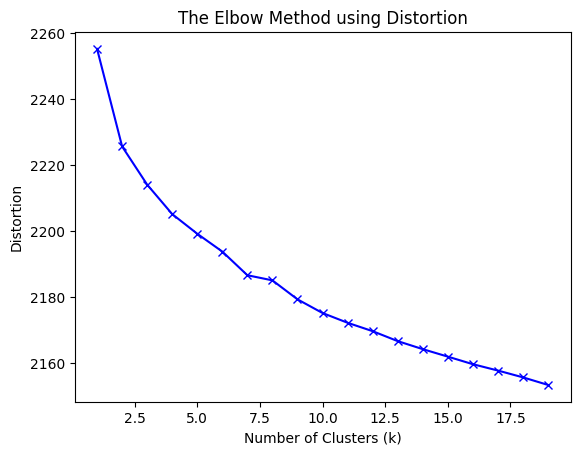

In [137]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Как и обычно ничего не дал.

### Смотрим на метрику

In [147]:
K = range(2, 15)
score = []

for k in tqdm(K):
    model = sk_cluster.KMeans(n_clusters=k, random_state=67)
    pred_model = model.fit_predict(data_clean.toarray())
    sc = metrics.calinski_harabasz_score(data_clean.toarray(), pred_model)
    score.append(sc)


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


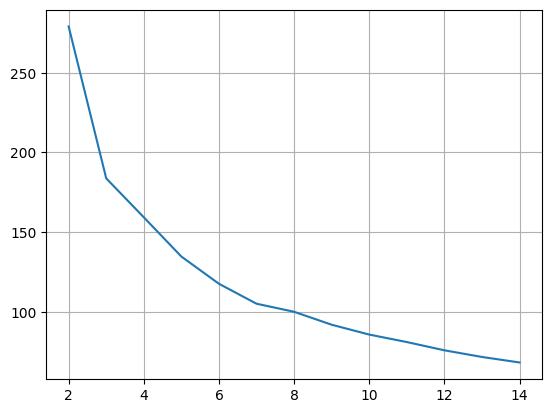

In [148]:
plt.plot(K, score)
plt.grid()

In [152]:
%%time
kmeans = sk_cluster.KMeans(n_clusters=2, random_state=67)
pred_kmeans_clean_2 = kmeans.fit_predict(data_clean.toarray())

CPU times: user 2.58 s, sys: 91.4 ms, total: 2.67 s
Wall time: 405 ms


In [153]:
metrics.calinski_harabasz_score(data_clean.toarray(), pred_kmeans_clean_2)

np.float64(279.0793234230933)

<Axes: >

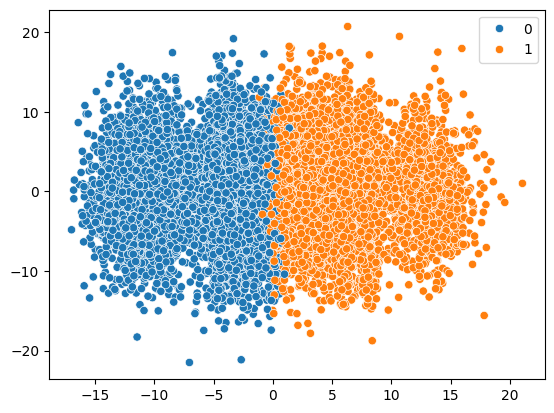

In [ ]:
sns.scatterplot(x=data_clean_2[:, 0], y=data_clean_2[:, 1], hue=pred_kmeans_clean_2)

Красота по всем параметрам. Пробуем:

In [156]:
save_pred(pred_kmeans_clean_2, 'submission_kmeans_clean_2.csv')

Score: 0.23576

Что-то не так.

## Думаем

* Пока лучше всего себя показал K-means с 4 кластерами. Ещё не пробовал GaussianMixture, но осталась последняя попытка.
* Возможно нужны все данные. При этом "нормировка" в бинарных признаках может помочь.
* Calinski-Harabasz Index больше нельзя считать показателем. Дальше придётся выбирать или другую метрику или действовать по наитию.
* Birch на такой размерности будет работать очень долго. Да и он уже давно не показывал хороших результатов.
* Может быть, на самом деле кластеров 3 или 5. Другие варианты (кроме 4) я считаю маловероятными.
* Можно ещё покрутить random_state. В случае K-means он может действительно быть полезным.
* Также можно нормализовывать те признаки, которые имеют нормальное распределение.

Судя по картинке, GaussianMixture дал примерно такие же результаты, поэтому его проверять не имеет смысла.

In [161]:
%%time
gm = sk_mixture.GaussianMixture(n_components=4, random_state=123)
pred_gm_clean = gm.fit_predict(data_clean.toarray())

CPU times: user 4min 21s, sys: 9.04 s, total: 4min 30s
Wall time: 25.1 s


In [162]:
metrics.adjusted_rand_score(pred_kmeans_clean, pred_gm_clean)

0.6114330802541069

Хотя отличия вроде бы достаточно существенные.

In [164]:
metrics.adjusted_rand_score(pred_kmeans_clean, pred_kmeans_clean_2)

0.4545226771088315

## Последняя попытка

Была неудачной. Score: 0.20352. Основывалась на MinMaxScaler + K-means. Также была попытка применить StandardScaler для непрерывных признаков, но видимо из-за наличия в одном столбце признаков из разных распределений это дало не очень хорошую картину.

Картинка для последнего примера (в другом пространстве):

<Axes: >

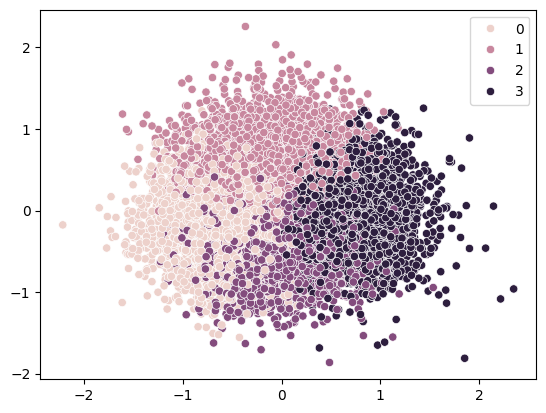

In [ ]:
# sns.scatterplot(x=data_last_2[:, 0], y=data_last_2[:, 1], hue=pred_kmeans_last)

# Итого

* Лучший результат - 0.41283. Достигнут на K-means'е с обрезанным количеством столбцов.
* Со Scaler'ами в задаче кластеризации нужно работать очень аккуратно, т.к. в одном столбце участвуют несколько распределений.
* Нужно учитывать специфику методов. В начале GaussianMixture показал себя не очень. Однако когда были оставлены только те признаки, которые наиболее вероятно являются непрерывными, он первый показал хороший результат.
* Теперь моя уверенность, что нули в этой задаче были NaN'ами, стала не такой большой.
* Метод локтя здесь никак не помог, сколько раз я не пытался его применять.
* Похоже, что выборка была сбалансированной, т.к. более-менее хорошие результаты были показаны тогда, когда в каждом классе было примерно одинаковое количество экземпляров.
* Также вероятно, что в выборке всего около 4 различных классов.

# Итоговый код

/home/zahar/BMSTU/techpark/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


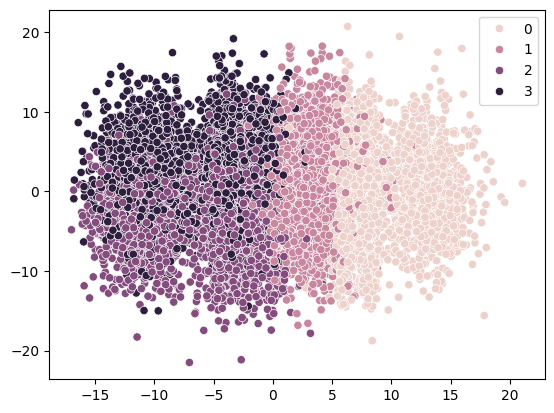

In [ ]:
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy import sparse
import seaborn as sns

import sklearn.cluster as sk_cluster
import sklearn.decomposition as sk_decomp

data = sparse.load_npz('train.npz')

def save_pred(pred, filename):
    submission = pd.read_csv('sample_submission.csv', index_col='ID')
    submission['TARGET'] = pred
    submission.to_csv(filename)

# Количество нулей в каждом столбце. Для ускорения вычисления это делается
# через подсчёт ненулевых компонент
zero_count = np.asarray(data.shape[0] - (data != 0).sum(axis=0))[0]

# В каких столбцах содержится key уникальных значений
feat_uniq_count = defaultdict(list)
for i in range(data.shape[1]):
    column_data = np.array(data[:, i].todense())[:, 0]
    uniq = np.unique(column_data)
    count_uniq = len(uniq)
    feat_uniq_count[count_uniq].append(i)

# Подправляем бинарные признаки
uniq_vals = {}
for col in feat_uniq_count[2]:
    column_data = np.array(data[:, col].todense())[:, 0]
    uniq, counts = np.unique(column_data, return_counts=True)
    uniq_vals[col] = (uniq, counts)

spec_1 = uniq_vals[174][0][0]
spec_2 = uniq_vals[219][0][1]

data_clean = sparse.load_npz('train.npz')

# Места, где лежат значения, которые нужно подправить
# Почему-то в numpy нельзя применить | для matrix, пришлось использовать обычное сложение
set_mask = (((data_clean[:, feat_uniq_count[2]] == spec_1) + (data_clean[:, feat_uniq_count[2]] == spec_2)) > 0)
data_clean[:, feat_uniq_count[2]] = np.where(set_mask.toarray(), 1.0, data_clean[:, feat_uniq_count[2]].toarray())
data_clean = data_clean[:, feat_uniq_count[2] + feat_uniq_count[3] + feat_uniq_count[21000]]

# Для визуализации
pca = sk_decomp.PCA(n_components=2)
data_clean_2 = pca.fit_transform(data_clean)

# На самом деле, при получении этих данных я забыл указать random_state.
# Поэтому я подобрал такой, при котором наиболее похожий результат
kmeans = sk_cluster.KMeans(n_clusters=4, random_state=192)
pred_kmeans_clean = kmeans.fit_predict(data_clean.toarray())
sns.scatterplot(x=data_clean_2[:, 0], y=data_clean_2[:, 1], hue=pred_kmeans_clean)
save_pred(pred_kmeans_clean, 'submission_kmeans_clean_4.csv')